In [2]:
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

import tensorflow as tf
from tensorflow import keras
from keras import preprocessing
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.models import Model
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D
import transformers as ppb # pytorch-pretrained-bert
# from transformers import_version_; print(_version_)
from transformers import BertTokenizer
from transformers import BertModel, BertForMaskedLM
import torch
import pipeline as pp
import models as ml
import numpy as np
import pandas as pd
import model_tests as mt
import importlib

# import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# conffusion matrix
from sklearn.metrics import confusion_matrix
# import seaborn as sns
import matplotlib.pyplot as plt
#f score
from sklearn.metrics import f1_score

2023-03-31 07:57:41.172153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Generate dataset

Generate dataset and apply binary labels to the data.

In [ ]:
importlib.reload(pp)


data = pp.apply_pipeline(
    '../datasets/big/dataset.csv',
    [(pp.Binary_labels(), 'type', 'type_binary') ],
    # classes=[True, False],
    # total_rows=100000,
    new_file='../datasets/big/dataset_bin_large.csv',
    progress_bar=True,
    nrows=1000000
)

# Split the data to training set

In [3]:
importlib.reload(pp)
fromfile = "../datasets/big/dataset_bin_large.csv"
nr_of_rows = 1000000
# fromfile = "../datasets/big/dataset_unbalanced_cleaned.csv"


pp.get_dataframe_with_distribution(fromfile, nr_of_rows, [0.8,0.1,0.1], [False, False, False], 
                                   out_file="../datasets/sample/dataset_unbalanced.csv", get_frame=False)


100%|██████████| 20000/20000 [00:00<00:00, 1108460.58it/s]


entries read: 1000000


## Cluster the data (optional)

To find underlying clusters in the data, we use the KMeans algorithm.


In [89]:
# Vectorize the corpus using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(cleaned_data['content_combined'].values.astype('U'))

### Plot the elbow curve to determine the optimal number of clusters.

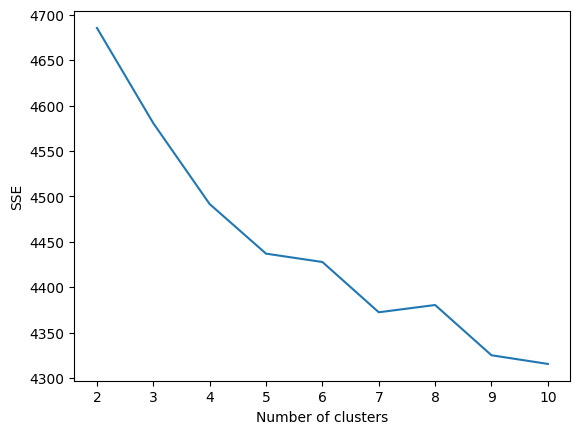

In [90]:
# Calculate SSE for different values of k
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

models = []

sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(tfidf)
    models.append(kmeans)
    sse[k] = kmeans.inertia_ 

# Plot SSE against k
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Define the number of clusters

In [91]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=10)
kmeans.fit(tfidf)

KMeans(max_iter=100, n_clusters=5, n_init=10)

### Plot the clusters using a a scatterplot in 2d with PCA.

In [92]:
label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}

In [ ]:
from sklearn.decomposition import PCA

# Reduce the dimensions of the data using PCA
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf.toarray())

colors = [label_to_color[label] for label in kmeans.labels_]

# Visualize the clusters
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], 
            c=colors, 
            cmap='rainbow',
            )
plt.show()

In [93]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

Top terms per cluster:
Cluster red terms: num, date, url, said, new, time, mr, peopl, state, year, 
Cluster blue terms: updat, bookmark, sputnik, pleas, dear, excit, radio, whitelist, adblock, voic, 
Cluster green terms: tor, tail, anonymis, usb, browser, dvd, submiss, stick, comput, internet, 
Cluster violet terms: rec, num, trump, republican, moor, date, diari, roy, senat, thread, 
Cluster yellow terms: iran, iranian, nuclear, suprem, islam, minist, leader, tehran, ali, republ, 


### Add the cluster labels to the data as a feature

In [150]:
cleaned_data['cluster'] = kmeans.labels_
# add the cluster label to the content

# concat the cluster label to the content

# create a new column 'cluster_color' that maps cluster labels to color codes
cleaned_data['cluster_color'] = cleaned_data['cluster'].map(label_to_color)

# create a new column 'cluster_string' that concatenates the color code and cluster label string
cleaned_data['cluster_string'] = cleaned_data['cluster_color'] + 'Cluster'

cleaned_data['content_with_cluster'] = cleaned_data['content_combined'] + ' ' + cleaned_data['cluster_string'].astype(str)

In [151]:
cleaned_data['content_with_cluster'][0]

'editor drop colleg editori march <num> written favor elector colleg reform sinc <date> would prefer popular elect presid gimmick endors individu state bind elector vote nation popularvot winner seem problemat one basic reason stop state legislatur strong partisan loyalti abandon agreement urgent calcul parti advantag come fore ? one legislatur anoth undo end difficult might presidentialelect reform depend take amend process serious that exampl editori cite conclus demonstr although individu state set legisl preced grant suffrag africanamerican women also popular elect senat end right entrench constitut amend left unstabl legisl gimmickri jack rakov stanford calif march <date> writer professor histori american studi polit scienc stanford univers draw draw thoma fuch redCluster'

### Add top termas as features

In [129]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    top_terms = ', '.join([terms[j] for j in order_centroids[i, :10]]).replace(',', '')
    print(top_terms)
    cleaned_data.loc[cleaned_data['cluster'] == i, 'content_with_top_terms'] = cleaned_data.loc[cleaned_data['cluster'] == i, 'content_combined'] + ' ' + top_terms

# write data to csv
# cleaned_data.to_csv("../datasets/sample/dataset_unbalanced_with_clusters.csv", index=False)

Top terms per cluster:
Cluster red terms: num date url said new time mr peopl state year
Cluster blue terms: updat bookmark sputnik pleas dear excit radio whitelist adblock voic
Cluster green terms: tor tail anonymis usb browser dvd submiss stick comput internet
Cluster violet terms: rec num trump republican moor date diari roy senat thread
Cluster yellow terms: iran iranian nuclear suprem islam minist leader tehran ali republ


In [115]:
# Clean_data("../datasets/sample/dataset_unbalanced_with_clusters.csv", "../datasets/big/dataset_unbalanced_cleaned.csv")
# cleaned_content_list = "content_tokenized"
# cleaned_content_string = "content_combined"

100%|██████████| 5000/5000 [00:00<00:00, 160401.40it/s]


processed 20000 rows
finish time: 33.5052752494812


In [130]:
# cleaned_data.head(1)
cleaned_data.iloc[0]['content_with_top_terms']

'editor drop colleg editori march <num> written favor elector colleg reform sinc <date> would prefer popular elect presid gimmick endors individu state bind elector vote nation popularvot winner seem problemat one basic reason stop state legislatur strong partisan loyalti abandon agreement urgent calcul parti advantag come fore ? one legislatur anoth undo end difficult might presidentialelect reform depend take amend process serious that exampl editori cite conclus demonstr although individu state set legisl preced grant suffrag africanamerican women also popular elect senat end right entrench constitut amend left unstabl legisl gimmickri jack rakov stanford calif march <date> writer professor histori american studi polit scienc stanford univers draw draw thoma fuch num date url said new time mr peopl state year'

### Get balanced or unbalanced dataset

In [34]:
# importlib.reload(pp)
# from_file = '../datasets/sample/dataset_bin_raw.csv'
# # from_file = '../datasets/sample/news_sample_cleaned_num_100k.csv'
# TOTALSIZE = 5000

# pp.get_dataframe_with_distribution(
#         from_file, 
#         total_size = TOTALSIZE, 
#         splits=[0.8,0.1,0.1], 
#         balanced=[False, False, False], 
#         out_file="../datasets/big/dataset_unbalanced.csv", 
#         get_frame=False
#     )



100%|██████████| 5000/5000 [00:00<00:00, 961026.49it/s]


entries to read: 0
entries read: 20000


In [78]:
pd.read_csv("../datasets/big/dataset_unbalanced_cleaned.csv").iloc[0]["content_tokenized"]

"['editor', 'drop', 'colleg', 'editori', 'march', '<num>', 'written', 'favor', 'elector', 'colleg', 'reform', 'sinc', '<date>', 'would', 'prefer', 'popular', 'elect', 'presid', 'gimmick', 'endors', 'individu', 'state', 'bind', 'elector', 'vote', 'nation', 'popularvot', 'winner', 'seem', 'problemat', 'one', 'basic', 'reason', 'stop', 'state', 'legislatur', 'strong', 'partisan', 'loyalti', 'abandon', 'agreement', 'urgent', 'calcul', 'parti', 'advantag', 'come', 'fore', '?', 'one', 'legislatur', 'anoth', 'undo', 'end', 'difficult', 'might', 'presidentialelect', 'reform', 'depend', 'take', 'amend', 'process', 'serious', 'that', 'exampl', 'editori', 'cite', 'conclus', 'demonstr', 'although', 'individu', 'state', 'set', 'legisl', 'preced', 'grant', 'suffrag', 'africanamerican', 'women', 'also', 'popular', 'elect', 'senat', 'end', 'right', 'entrench', 'constitut', 'amend', 'left', 'unstabl', 'legisl', 'gimmickri', 'jack', 'rakov', 'stanford', 'calif', 'march', '<date>', 'writer', 'professor',

# Define the models

### Tokenize the data and make sequences

In [5]:
importlib.reload(mt)

# data = pd.read_csv("../datasets/sample/dataset_unbalanced_1M.csv", usecols=["content_combined", "type_binary","set"])
data = pd.read_csv("../datasets/sample/dataset_unbalanced.csv", usecols=["content_combined", "type_binary","set"])
data.head(1)

X_train, X_val, X_test, y_train, y_val, y_test = mt.split_data(data, "content_combined", "type_binary")
del data

In [110]:
importlib.reload(pp)

pp.apply_pipeline("../datasets/big/combined_cleaned_bin.csv", [(pp.Binary_labels_LIAR(), 'label', 'type_binary')], new_file="../datasets/big/combined_cleaned_bin.csv")

processed 20000 rows
finish time: 0.19864916801452637


In [8]:
liar_data = pd.read_csv("../datasets/big/combined_cleaned_bin.csv")
X_liar =  liar_data["statement_combined"].values
y_liar = liar_data["type_binary"].astype(int)

## Neural networks

In [11]:
importlib.reload(mt)
vocab_len = 10.000 # size of vocabulary e.g
max_seq_length = 60 # first nr. of words
X_train_pad, X_val_pad, X_test_pad, X_liar_pad, vocab_len = mt.create_padded_sequences(X_train, X_val, X_test, X_liar, numwords=vocab_len, maxlen=max_seq_length)

916958


In [15]:
vocab = vocab_len # size of vocabulary e.g
embedding_vector_length = 16 # dimension of embedding vector

# Define the model architecture
models = [
    (tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab, output_dim=embedding_vector_length, input_length=max_seq_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]), "Model-A"),

    (tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab, output_dim=embedding_vector_length, input_length=max_seq_length), # 10000 words, 64 dimensions
        tf.keras.layers.LSTM(units=16, dropout=0.2, recurrent_dropout=0.2),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ]), "Model-B"),


    (tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab, output_dim=embedding_vector_length, input_length=max_seq_length), # 10000 words, 64 dimensions
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(100),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='sigmoid')
    ]), "Model-C"),

    (tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab, output_dim=embedding_vector_length, input_length=max_seq_length),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]), "Model-E"),
]   

modelFits = []

for model, name in models:
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    model.summary()

for model, name in models:
    print(f"Training {name}")
    # Train the model
    history = model.fit(X_train_pad, y_train, epochs=4, validation_data=(X_val_pad, y_val))
    modelFits.append((history, name))

    # Evaluate the model
    metrics = model.evaluate(X_val_pad, y_val)
    print(f"Loss {metrics[0]}, Accuracy {metrics[1]}, Precision {metrics[2]}, Recall {metrics[3]}")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 60, 16)            14671328  
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 14,671,617
Trainable params: 14,671,617
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)       

dict_keys(['loss', 'accuracy', 'precision_57', 'recall_57', 'val_loss', 'val_accuracy', 'val_precision_57', 'val_recall_57'])


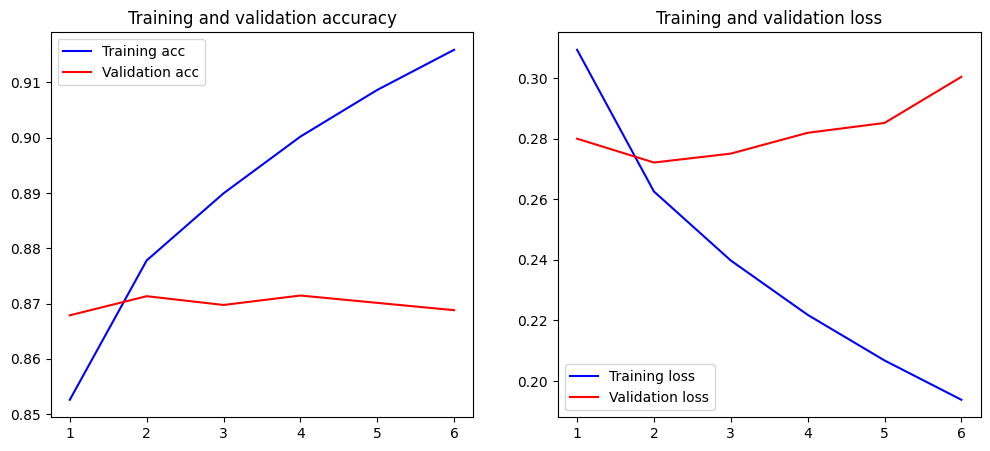

In [119]:
fit, name = modelFits[0]
mt.plot_history(fit)

In [ ]:
importlib.reload(mt)
# import seaborn as sns


for model, name in models:
    # Evaluate the model
    print(f"Evaluating {name}")
    y_pred = model.predict(X_test_pad).round()
    #print(mt.get_metrics(y_test, y_pred))
    print(f"Confusion matrix for {name}")
    cm = confusion_matrix(y_test, y_pred)
    # print 0,0
    print("Fake news predicted correctly:", k)
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Fake","True"], yticklabels=["Fake","True"], fmt="d", annot_kws={"size": 12})
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    metrics = model.evaluate(X_val_pad, y_val, verbose=0)
    print(f"VAL: Loss {metrics[0]}, Accuracy {metrics[1]}, Precision {metrics[2]}, Recall {metrics[3]} f1: {(2 * (metrics[2] * metrics[3]) / (metrics[2] + metrics[3]))}")
    metrics = model.evaluate(X_test_pad, y_test, verbose=0)
    print(f"TEST: Loss {metrics[0]}, Accuracy {metrics[1]}, Precision {metrics[2]}, Recall {metrics[3]}, f1: {(2 * (metrics[2] * metrics[3]) / (metrics[2] + metrics[3]))}")
    metrics = model.evaluate(X_liar, y_liar, verbose=0)
    print(f"LIAR: Loss {metrics[0]}, Accuracy {metrics[1]}, Precision {metrics[2]}, Recall {metrics[3]} f1: {(2 * (metrics[2] * metrics[3]) / (metrics[2] + metrics[3]))}")


### LSTM + glove model

In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# Download and load pre-trained GloVe embeddings
embeddings_index = {}
with open('../datasets/glove/glove.6B.100d.txt', encoding='utf8') as f: # http://nlp.stanford.edu/data/glove.6B.zip
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Tokenize input text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_val_sequence = tokenizer.texts_to_sequences(X_val)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index 
print(word_index)

# Pad input sequences
max_len = 100
X_train_pad = pad_sequences(X_train_sequence, maxlen=max_len)
X_val_pad = pad_sequences(X_val_sequence, maxlen=max_len)
X_test_pad = pad_sequences(X_test_sequence, maxlen=max_len)

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define model
model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Flatten(),
    Dense(1, activation='sigmoid')
])



# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train model
model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val))
metrics = model.evaluate(X_val_pad, y_val)
